## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd
import networkx as nx

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)

##  Select your link

In [2]:
sS='UC'
srcSiteOWDServer = "192.170.227.160"
srcSiteThroughputServer = "192.170.227.162"

# sS='IU'
# srcSiteOWDServer = "149.165.225.223"
# srcSiteThroughputServer = "149.165.225.224"

dS='UIUC'
destSiteOWDServer = "72.36.96.4"
destSiteThroughputServer = "72.36.96.9"

## Get the data from Elasticsearch, and store the record based on its type

In [14]:
my_query = {
    'query':{
            'bool':{
                   'must':[
                       {'range': {'timestamp': {'gte': '20170101T000000Z', 'lt': '20170401T235959Z'}}},
                       {'bool':
                           {'should':[
                               {'term': {'src': srcSiteOWDServer}},
                               {'term': {'src': srcSiteThroughputServer}},
                               {'term': {'src': destSiteOWDServer}},
                               {'term': {'src': destSiteThroughputServer}}
                           ]}
                       },
                       {'bool':
                           {'should':[
                               {'term': {'dest': destSiteOWDServer}},
                               {'term': {'dest': destSiteThroughputServer}},
                               {'term': {'dest': srcSiteOWDServer}},
                               {'term': {'dest': srcSiteThroughputServer}}
                           ]}
                       }
                   ]
            }
    }
}

scroll = list(scan(client=es, index="network_weather-2017*", query=my_query))


In [19]:
site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
edges={}
edges[sS]={}
edges[dS]={}
for res in scroll:
    count += 1
    dt=datetime.strptime(res['_source']['timestamp'], '%Y%m%dT%H%M%S+0000')
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'latency':
        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
    elif column_type == 'traceroute':
        data[s].set_value( ts, 'hash', res['_source']['hash'])
        ho=res['_source']['hops']
        cn=res['_source']['src'] # first device is not in list of hops
        for n in ho: # adding nodes
            if cn not in edges[s]: edges[s][cn]={}
            if n not in edges[s][cn]: 
                edges[s][cn][n]=1
            else:
                edges[s][cn][n]+=1
            cn=n
        #print(edges)
    if count<2: print(res, ts)
print(count)

{'_type': 'traceroute', '_id': 'AVobkw-MsxHoI1r8bnss', '_index': 'network_weather-2017.2.8', '_score': None, '_source': {'destProduction': True, 'MA': '192.170.227.162', 'destVO': 'ATLAS', 'destSite': 'MWT2', 'dest': '72.36.96.9', 'src': '192.170.227.162', 'srcVO': 'ATLAS', 'hash': 6080203815649007419, 'hops': ['192.170.226.1', '192.170.224.106', '192.170.224.98', '72.36.80.13', '130.126.1.110', '72.36.96.9'], 'rtts': [0.352, 9.677, 0.205, 4.769, 4.24, 3.329], 'srcSite': 'MWT2', 'srcProduction': True, 'ttls': [1, 2, 3, 4, 5, 6], 'timestamp': '20170208T032222+0000'}, 'sort': [2]} 1486524142000.0
595119


### saving in pickle files

In [30]:
a=data[sS]
print (a.count(axis='index'))
a.sort_index(inplace=True)    # Sort the records based on time
#a.to_pickle("Data/FullOneLinkData" + '_' + sS + '-' + dS + ".pkl")
a.to_csv("Data/FullOneLinkData" + '_' + sS + '-' + dS + ".csv")

a=data[dS]
print (a.count(axis='index'))
a.sort_index(inplace=True)    # Sort the records based on time
#a.to_pickle("Data/FullOneLinkData" + '_' + dS + '-' + sS + ".pkl")
a.to_csv("Data/FullOneLinkData" + '_' + dS + '-' + sS + ".csv")

timestamp       27521
hash            10810
delay_median    16072
delay_mean      16072
delay_sd        16072
packet_loss     16072
throughput        674
dtype: int64
timestamp       27624
hash            10790
delay_median    16284
delay_mean      16284
delay_sd        16284
packet_loss     16284
throughput        593
dtype: int64


### Select a pair of source - destination

In [26]:
F = data[sS]
B = data[dS]
Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
Fd = F[F.delay_mean<4]
Bd = B[B.delay_mean<4]

Fh = F[F.hash.notnull()]
Bh = B[B.hash.notnull()]
Fu, Fids = np.unique(Fh.hash, return_inverse=True)
Bu, Bids = np.unique(Bh.hash, return_inverse=True)


In [27]:
# Fthr

In [28]:
print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])
print(edges)

throughput  forward:  674  backward:  593
packet loss forward:  16072  backward:  16284
delay       forward:  16042  backward:  16195
hash        forward:  10810  backward:  10790
{'UIUC': {'72.36.96.9': {'72.36.96.1': 10810}, '72.36.96.1': {'130.126.1.109': 10810}, '72.36.80.14': {'192.170.224.107': 6034, None: 67, '192.170.224.94': 481, '192.170.224.97': 4228}, '192.170.224.94': {None: 1, '192.170.227.162': 480}, '192.170.224.107': {None: 17, '192.170.227.162': 6017}, '192.170.224.78': {None: 10, '192.170.227.162': 4049}, '130.126.1.109': {'72.36.80.14': 10810}, None: {None: 140, '192.170.227.162': 236}, '192.170.224.97': {None: 169, '192.170.224.78': 4059}}, 'UC': {None: {'72.36.96.9': 1, None: 66, '192.170.224.106': 73, '192.170.224.98': 1, '192.170.224.77': 197, '72.36.80.13': 1, '130.126.1.110': 3, '192.170.227.162': 1}, '192.170.226.1': {None: 1, '192.170.224.77': 4522, '192.170.224.93': 1, '192.170.224.106': 6037}, '72.36.80.13': {None: 1, '130.126.1.110': 10826}, '192.170.224.

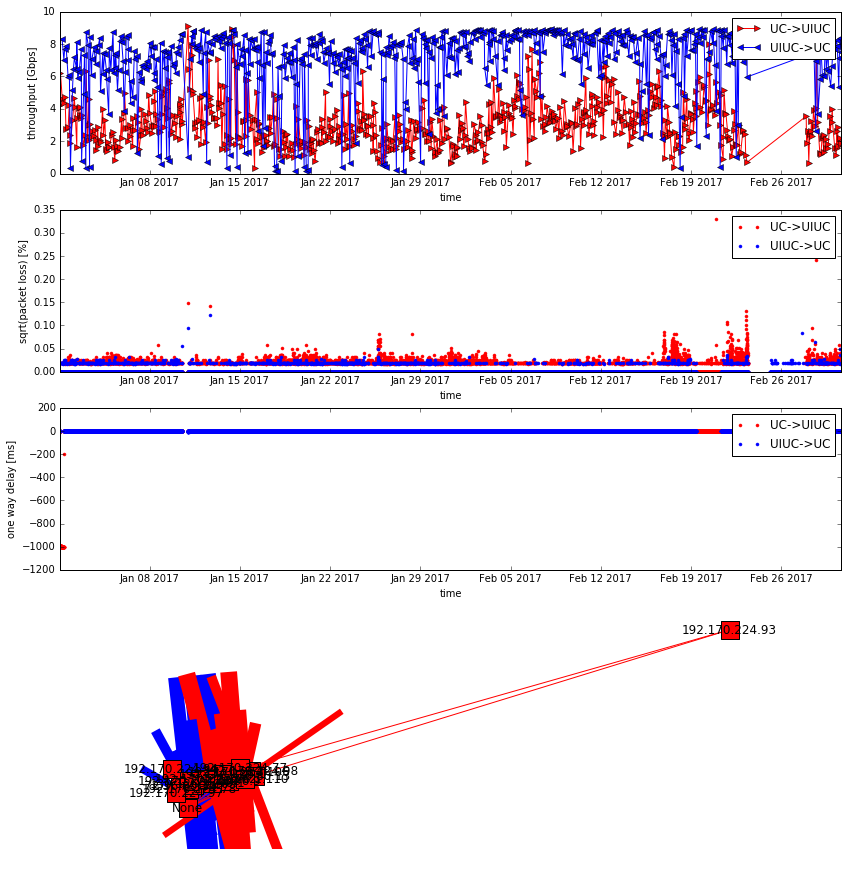

In [29]:
plt.figure(figsize=[14, 15])
gs = gridspec.GridSpec(4, 1, height_ratios=[2,2,2,3])

ax0 = plt.subplot(gs[0])
ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#plt.xlim(xmin=0)
ax0.legend()

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()


ax4 = plt.subplot(gs[2])
ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()


ax5 = plt.subplot(gs[3])
G=nx.Graph()
for p in edges[sS]:
    for s in edges[sS][p]:
        G.add_edge(p,s,color='r',weight=edges[sS][p][s])
for p in edges[dS]:
    for s in edges[dS][p]:
        G.add_edge(p,s,color='b',weight=edges[dS][p][s])
        
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=200)
# nx.draw_networkx_edges(G,pos)

dedges = G.edges()
colors = [G[u][v]['color'] for u,v in dedges]
weights = [math.ceil(G[u][v]['weight']/50) for u,v in dedges]

nx.draw(G, pos, edges=dedges, edge_color=colors,node_shape='s', width=weights,with_labels=True)
# nx.draw_networkx_labels(G,pos,font_size=15,font_family='sans-serif')

plt.axis('off')
plt.savefig('Plots/AllPlotForLinkSimple_' + sS +'_'+ dS + '.png')
plt.show()